In [1]:
import sys, os
# local_path = "/homes/s17ouala/Bureau/Sanssauvegarde/NbedDyn-main"
local_path = '/Users/matthewlevine/code_projects/NbedDyn'
sys.path.append(os.path.join(local_path, 'code/modules'))
import pickle
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.decomposition import PCA
import torch
from dynamical_models   import *
from generate_data      import *
from NbedDyn            import *
from stat_functions     import *

In [2]:
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 110.01 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 0.0 # variance of the observation error to generate observation

# run the data generation
X_train_chaos = Attractor_Lorenz = np.load(os.path.join(local_path,'data/X_train_L63_CHAOS.npy'))
X_test  = np.load(os.path.join(local_path,'data/X_test_CHAOS.npy'))

In [3]:
X_train    = X_train_chaos[:,:1]#[:-1,:1]
Grad_t     = np.gradient(X_train[:,0]).reshape(X_train.shape[0],1)/GD.dt_integration
Batch_size = X_train.shape[0]
nb_batch   = int(X_train.shape[0]/Batch_size)
X_train    = X_train.reshape(nb_batch,Batch_size,1)
Grad_t     = Grad_t.reshape(nb_batch,Batch_size,1)

In [4]:
N_lat = 2
params = {}
params['seed']               = 0
params['transition_layers']  = 1
params['bi_linear_layers']   = N_lat+1
params['dim_hidden_linear']  = N_lat+1
params['dim_input']          = 1
params['dim_latent']         = N_lat
params['dim_observations']   = 1
params['dim_Embedding']      = N_lat+1
params['ntrain']             = [30000,1000]
params['dt_integration']     = 0.01
params['pretrained']         = False
params['nb_batch']           = nb_batch
params['Batch_size']         = Batch_size
params['get_latent_train']   = False
params['path']               = ''
params['file_name']          = 'NbedDyn_L63_dim_'+str(params['dim_Embedding'])+'_seed_'+str(params['seed'])

In [5]:
for N_lat in range(2,3):
    for seed in range(0,1):
        params = {}
        params['seed']               = seed
        params['transition_layers']  = 1
        params['bi_linear_layers']   = N_lat+1
        params['dim_hidden_linear']  = N_lat+1
        params['dim_input']          = 1
        params['dim_latent']         = N_lat
        params['dim_observations']   = 1
        params['dim_Embedding']      = N_lat+1
        params['ntrain']             = [30000,1000]
        params['dt_integration']     = 0.01
        params['pretrained']         = False
        params['nb_batch']           = nb_batch
        params['Batch_size']         = Batch_size
        params['get_latent_train']   = False
        params['path']               = ''
        params['file_name']          = 'NbedDyn_L63_dim_'+str(params['dim_Embedding'])+'_seed_'+str(params['seed'])
        model, modelRINN = get_NbedDyn_model(params)
        model, modelRINN, aug_inp_data = train_NbedDyn_model_L63(params,model,modelRINN,X_train,Grad_t)
        pred = [torch.cat((torch.from_numpy(X_train).float()[-1,-1:,:], modelRINN.Dyn_net.y_aug[-1,-1:,:]), dim=1)]

        for i in range(10000):
            pred.append(modelRINN(pred[-1],params['dt_integration'])[0])

        forecasting_err=np.zeros(1000)
        for i in range(1,100):
            forecasting_err[i-1]=RMSE(X_test[i-1,0],torch.stack(pred).data.numpy()[i,0,0])

        print('prediction error at t0 + dt : '  ,forecasting_err[0])
        print('prediction error at t0 + 4dt : ' ,forecasting_err[3])

#         l_exp, l_dim = Compute_Lyapunov_spectrum(modelRINN, np.concatenate((X_train[-1,-1,:], modelRINN.Dyn_net.y_aug.detach().numpy()[-1,-1,:]), axis=0), 10000, 0.1, 0.01, True)
#         lyap_series =  compute_largest_Lyapunov(modelRINN, np.concatenate((X_train[-1,-1,:], modelRINN.Dyn_net.y_aug.detach().numpy()[-1,-1,:]), axis=0),0.01,0.1,10000, True)[0]

#         print(l_exp)
#         print(lyap_series[-1])
#         print(l_dim)

#         output_results = {}
#         output_results['description']    = 'nbedDyn_model_output_dim'+str(params['dim_observations'])+'_seed_'+str(seed)
#         output_results['pred']           = torch.stack(pred).data.numpy()
#         output_results['lyap_spect']     = l_exp
#         output_results['lyap_dim']       = l_dim
#         output_results['largest_lyap']   = lyap_series
#         output_results['forecast_error'] = forecasting_err
#         # write python dict to a file
#         output = open(params['path']+params['file_name']+'.pkl', 'wb')
#         pickle.dump(output_results, output)
#         output.close()

0.001
Training L63 NbedDyn model 0 tensor(1519.1263, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 1000 tensor(0.0945, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 2000 tensor(0.0010, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 3000 tensor(0.0008, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 4000 tensor(0.0007, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 5000 tensor(0.0006, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 6000 tensor(0.0005, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 7000 tensor(0.0005, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 8000 tensor(0.0005, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 9000 tensor(0.0004, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 10000 tensor(0.0004, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 11000 tensor(0.0004, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 12000 tensor(0.0004, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 13000 tensor(0.0003, grad_fn=<AddBackward

NameError: name 'l_exp' is not defined

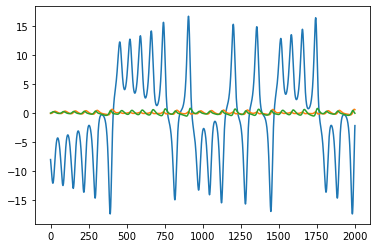

In [6]:
plt.plot(torch.stack(pred)[:2000,0,:].detach())

# forecast at test time :
1) viz test time series

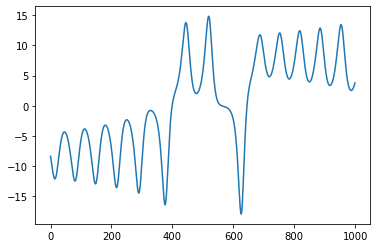

In [7]:
plt.plot(X_test[:,0])

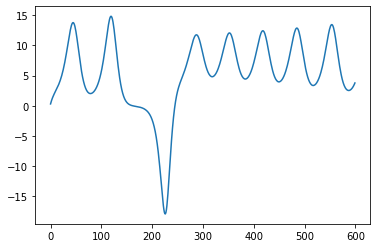

In [8]:
# forecast at starting from t0 = 400*dt :
plt.plot(X_test[400:,0])

# Simple method : find analogs for the latent states in the training set:

In [9]:
def get_init(test_vars,length_prior,dt,dim_aug):
    x = torch.from_numpy(X_train).float()
    aug_inp = torch.cat((x[0,:,:], modelRINN.Dyn_net.y_aug[0,:,:]), dim=1)
    pred, grad, inp, aug_inp = modelRINN(aug_inp,dt)
    pred, aug = model_Multi_RINN(aug_inp, 0.0, length_prior, dt)
    loss_init=[]
    for i in range(aug_inp.shape[0]):
        loss_init.append(((pred[1:,i,:1][torch.where(~torch.isnan(test_vars))]-test_vars[torch.where(~torch.isnan(test_vars))])**2).mean())
    min_idx = np.where(torch.stack(loss_init).data.numpy()==torch.stack(loss_init).data.numpy().min())
    inp_init = aug_inp.detach().data.numpy()[min_idx[0][0]].reshape(1,dim_aug)
    inp_init = (torch.from_numpy(inp_init).float())
    return inp_init
class Multi_INT_net(torch.nn.Module):
        def __init__(self, params):
            super(Multi_INT_net, self).__init__()
#            self.add_module('Dyn_net',FC_net(params))
            self.Int_net = modelRINN
        def forward(self, inp, t0, nb, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
#            dt = Variable(torch.from_numpy(np.reshape(dt,(1,1))).float())
#            x = Variable(3*torch.ones(1, 1), requires_grad=True)

            #grad, aug_inp = self.Dyn_net(inp,dt)
            #pred = aug_inp +dt*grad
            pred = [inp]
            aug  = []
            for i in range(nb):
                predic, k1, inp, aug_inp = self.Int_net(pred[-1], dt)
                pred.append(predic)
                aug.append(aug_inp)
            return torch.stack(pred), torch.stack(aug)
model_Multi_RINN = Multi_INT_net(params)
criterion = torch.nn.MSELoss()

In [10]:
initial_cond_idx = 400
length_prior     = 1 # length of the initial condition

test_vars = (torch.from_numpy(np.reshape(X_test[initial_cond_idx:initial_cond_idx+length_prior,0],(length_prior,1))).float())
inp_init = get_init(test_vars,length_prior,0.01,params['dim_Embedding'])

y_pred2=np.zeros((2000+length_prior+1,params['dim_Embedding']))
tmp = inp_init
y_pred2[0,:] = tmp.cpu().data.numpy()
for k in range(1,2000+length_prior+1):
    y_pred2[k,:] = modelRINN(tmp,0.01)[0].cpu().data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred2[k,:],(1,params['dim_Embedding']))).float())

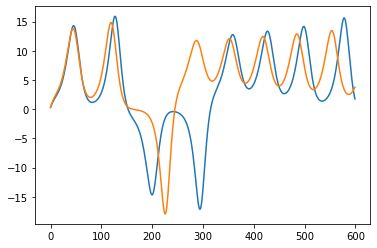

In [11]:
plt.plot(y_pred2[1:600+1,0])
plt.plot(X_test[400:,0])

In [12]:
initial_cond_idx = 400
length_prior     = 3

test_vars = (torch.from_numpy(np.reshape(X_test[initial_cond_idx:initial_cond_idx+length_prior,0],(length_prior,1))).float())
inp_init = get_init(test_vars,length_prior,0.01,params['dim_Embedding'])

y_pred2=np.zeros((2000+length_prior+1,params['dim_Embedding']))
tmp = inp_init
y_pred2[0,:] = tmp.cpu().data.numpy()
for k in range(1,2000+length_prior+1):
    y_pred2[k,:] = modelRINN(tmp,0.01)[0].cpu().data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred2[k,:],(1,params['dim_Embedding']))).float())

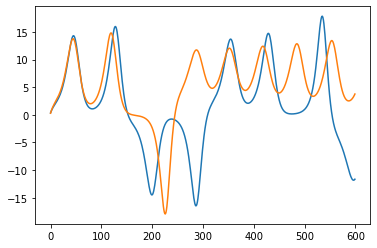

In [13]:
plt.plot(y_pred2[1:600+1,0])
plt.plot(X_test[400:,0])

# Second method : optimize initial condition of the latent states to forecast the initial condition of the observations

In [14]:
def get_initial_condition(model, time_series, train_series, dt,lr_init, err_tol = 1E-4, n_train = 10000, get_init_in_train_set = True):
    criterion = torch.nn.MSELoss()#reduction = 'sum')
    if get_init_in_train_set :
        print(time_series.shape)
        inp_init = get_init(time_series,time_series.shape[0],0.01,params['dim_Embedding'])
    else:
        min_idx = None
        inp_init = torch.rand(1,(train_series.shape[-1]+model.Int_net.Dyn_net.y_aug.shape[-1])).float()*0.0
        inp_init[:,:time_series.shape[-1]] = time_series.clone()[:1,:]
    init_cond_model = get_init_model(model,inp_init)
    optimizer = torch.optim.Adam(init_cond_model.parameters(), lr = lr_init)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor = 0.1, patience=205, verbose=True, min_lr = 0.0001)
    stop_cond = False
    count = 0
    while(stop_cond==False):
        # Forward pass: Compute predicted y by passing x to the model
        pred = init_cond_model(0.0,time_series.shape[0],dt)
        #pred1, grad, inp, aug_inp = modelRINN(test_vars[:1,:],dt, True, iterate = t)
        # Compute and print loss
        loss = torch.mean((pred[1:,0,:time_series.shape[-1]][torch.where(~torch.isnan(time_series))]- time_series[torch.where(~torch.isnan(time_series))])**2)
#        criterion(pred[1:,0,:time_series.shape[-1]], time_series[:,:])
        print(count,loss)
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step(loss)
        count += 1
        if loss.detach().numpy()<err_tol or count>n_train:
            stop_cond = True
    return inp_init, init_cond_model.estimate_init

class get_init_model(torch.nn.Module):
        def __init__(self, model_Multi_RINN, inp_init):
            super(get_init_model, self).__init__()
            self.Multi_INT_net = model_Multi_RINN
            self.estimate_init = torch.nn.Parameter((inp_init.clone()))#torch.nn.Parameter(aug_inp[:1,:])
        def forward(self, t0, nb, dt):
            pred = self.Multi_INT_net(self.estimate_init, t0, nb, dt)[0]
            return pred

In [15]:
initial_cond_idx = 400
length_prior     = 2
train_series = torch.from_numpy(X_train).float()
inp_init_knn, inp_init_opti = get_initial_condition(model_Multi_RINN, torch.from_numpy(X_test[initial_cond_idx:initial_cond_idx+length_prior,:1]).float(), train_series, 0.01,lr_init = 0.9, err_tol = 1E-4, n_train = 10000, get_init_in_train_set = True)

torch.Size([2, 1])
0 tensor(0.0017, grad_fn=<MeanBackward0>)
1 tensor(1.2333e+20, grad_fn=<MeanBackward0>)
2 tensor(17388.7676, grad_fn=<MeanBackward0>)
3 tensor(17.3446, grad_fn=<MeanBackward0>)
4 tensor(1.2735, grad_fn=<MeanBackward0>)
5 tensor(0.6844, grad_fn=<MeanBackward0>)
6 tensor(6.3207, grad_fn=<MeanBackward0>)
7 tensor(15.1418, grad_fn=<MeanBackward0>)
8 tensor(27.0572, grad_fn=<MeanBackward0>)
9 tensor(20137.9453, grad_fn=<MeanBackward0>)
10 tensor(4.3423e+20, grad_fn=<MeanBackward0>)
11 tensor(7.2587e+18, grad_fn=<MeanBackward0>)
12 tensor(1.1279e+17, grad_fn=<MeanBackward0>)
13 tensor(1.9365e+15, grad_fn=<MeanBackward0>)
14 tensor(3.8549e+13, grad_fn=<MeanBackward0>)
15 tensor(9.0051e+11, grad_fn=<MeanBackward0>)
16 tensor(2.4356e+10, grad_fn=<MeanBackward0>)
17 tensor(7.2620e+08, grad_fn=<MeanBackward0>)
18 tensor(20468188., grad_fn=<MeanBackward0>)
19 tensor(268814.5312, grad_fn=<MeanBackward0>)
20 tensor(19077.4551, grad_fn=<MeanBackward0>)
21 tensor(34500.7266, grad_fn

203 tensor(54.2572, grad_fn=<MeanBackward0>)
204 tensor(54.2572, grad_fn=<MeanBackward0>)
205 tensor(54.2572, grad_fn=<MeanBackward0>)
206 tensor(54.2572, grad_fn=<MeanBackward0>)
Epoch   207: reducing learning rate of group 0 to 9.0000e-02.
207 tensor(54.2572, grad_fn=<MeanBackward0>)
208 tensor(54.2572, grad_fn=<MeanBackward0>)
209 tensor(54.2572, grad_fn=<MeanBackward0>)
210 tensor(54.2572, grad_fn=<MeanBackward0>)
211 tensor(54.2572, grad_fn=<MeanBackward0>)
212 tensor(54.2572, grad_fn=<MeanBackward0>)
213 tensor(54.2572, grad_fn=<MeanBackward0>)
214 tensor(54.2572, grad_fn=<MeanBackward0>)
215 tensor(54.2572, grad_fn=<MeanBackward0>)
216 tensor(54.2572, grad_fn=<MeanBackward0>)
217 tensor(54.2572, grad_fn=<MeanBackward0>)
218 tensor(54.2572, grad_fn=<MeanBackward0>)
219 tensor(54.2572, grad_fn=<MeanBackward0>)
220 tensor(54.2572, grad_fn=<MeanBackward0>)
221 tensor(54.2572, grad_fn=<MeanBackward0>)
222 tensor(54.2572, grad_fn=<MeanBackward0>)
223 tensor(54.2572, grad_fn=<MeanBackw

391 tensor(54.2572, grad_fn=<MeanBackward0>)
392 tensor(54.2572, grad_fn=<MeanBackward0>)
393 tensor(54.2572, grad_fn=<MeanBackward0>)
394 tensor(54.2572, grad_fn=<MeanBackward0>)
395 tensor(54.2572, grad_fn=<MeanBackward0>)
396 tensor(54.2572, grad_fn=<MeanBackward0>)
397 tensor(54.2572, grad_fn=<MeanBackward0>)
398 tensor(54.2572, grad_fn=<MeanBackward0>)
399 tensor(54.2572, grad_fn=<MeanBackward0>)
400 tensor(54.2572, grad_fn=<MeanBackward0>)
401 tensor(54.2572, grad_fn=<MeanBackward0>)
402 tensor(54.2572, grad_fn=<MeanBackward0>)
403 tensor(54.2572, grad_fn=<MeanBackward0>)
404 tensor(54.2572, grad_fn=<MeanBackward0>)
405 tensor(54.2572, grad_fn=<MeanBackward0>)
406 tensor(54.2572, grad_fn=<MeanBackward0>)
407 tensor(54.2572, grad_fn=<MeanBackward0>)
408 tensor(54.2572, grad_fn=<MeanBackward0>)
409 tensor(54.2572, grad_fn=<MeanBackward0>)
410 tensor(54.2572, grad_fn=<MeanBackward0>)
411 tensor(54.2572, grad_fn=<MeanBackward0>)
412 tensor(54.2572, grad_fn=<MeanBackward0>)
Epoch   41

582 tensor(54.2572, grad_fn=<MeanBackward0>)
583 tensor(54.2572, grad_fn=<MeanBackward0>)
584 tensor(54.2572, grad_fn=<MeanBackward0>)
585 tensor(54.2572, grad_fn=<MeanBackward0>)
586 tensor(54.2572, grad_fn=<MeanBackward0>)
587 tensor(54.2572, grad_fn=<MeanBackward0>)
588 tensor(54.2572, grad_fn=<MeanBackward0>)
589 tensor(54.2572, grad_fn=<MeanBackward0>)
590 tensor(54.2572, grad_fn=<MeanBackward0>)
591 tensor(54.2572, grad_fn=<MeanBackward0>)
592 tensor(54.2572, grad_fn=<MeanBackward0>)
593 tensor(54.2572, grad_fn=<MeanBackward0>)
594 tensor(54.2572, grad_fn=<MeanBackward0>)
595 tensor(54.2572, grad_fn=<MeanBackward0>)
596 tensor(54.2572, grad_fn=<MeanBackward0>)
597 tensor(54.2572, grad_fn=<MeanBackward0>)
598 tensor(54.2572, grad_fn=<MeanBackward0>)
599 tensor(54.2572, grad_fn=<MeanBackward0>)
600 tensor(54.2572, grad_fn=<MeanBackward0>)
601 tensor(54.2572, grad_fn=<MeanBackward0>)
602 tensor(54.2572, grad_fn=<MeanBackward0>)
603 tensor(54.2572, grad_fn=<MeanBackward0>)
604 tensor

763 tensor(54.2572, grad_fn=<MeanBackward0>)
764 tensor(54.2572, grad_fn=<MeanBackward0>)
765 tensor(54.2572, grad_fn=<MeanBackward0>)
766 tensor(54.2572, grad_fn=<MeanBackward0>)
767 tensor(54.2572, grad_fn=<MeanBackward0>)
768 tensor(54.2572, grad_fn=<MeanBackward0>)
769 tensor(54.2572, grad_fn=<MeanBackward0>)
770 tensor(54.2572, grad_fn=<MeanBackward0>)
771 tensor(54.2572, grad_fn=<MeanBackward0>)
772 tensor(54.2572, grad_fn=<MeanBackward0>)
773 tensor(54.2572, grad_fn=<MeanBackward0>)
774 tensor(54.2572, grad_fn=<MeanBackward0>)
775 tensor(54.2572, grad_fn=<MeanBackward0>)
776 tensor(54.2572, grad_fn=<MeanBackward0>)
777 tensor(54.2572, grad_fn=<MeanBackward0>)
778 tensor(54.2572, grad_fn=<MeanBackward0>)
779 tensor(54.2572, grad_fn=<MeanBackward0>)
780 tensor(54.2572, grad_fn=<MeanBackward0>)
781 tensor(54.2572, grad_fn=<MeanBackward0>)
782 tensor(54.2572, grad_fn=<MeanBackward0>)
783 tensor(54.2572, grad_fn=<MeanBackward0>)
784 tensor(54.2572, grad_fn=<MeanBackward0>)
785 tensor

952 tensor(54.2572, grad_fn=<MeanBackward0>)
953 tensor(54.2572, grad_fn=<MeanBackward0>)
954 tensor(54.2572, grad_fn=<MeanBackward0>)
955 tensor(54.2572, grad_fn=<MeanBackward0>)
956 tensor(54.2572, grad_fn=<MeanBackward0>)
957 tensor(54.2572, grad_fn=<MeanBackward0>)
958 tensor(54.2572, grad_fn=<MeanBackward0>)
959 tensor(54.2572, grad_fn=<MeanBackward0>)
960 tensor(54.2572, grad_fn=<MeanBackward0>)
961 tensor(54.2572, grad_fn=<MeanBackward0>)
962 tensor(54.2572, grad_fn=<MeanBackward0>)
963 tensor(54.2572, grad_fn=<MeanBackward0>)
964 tensor(54.2572, grad_fn=<MeanBackward0>)
965 tensor(54.2572, grad_fn=<MeanBackward0>)
966 tensor(54.2572, grad_fn=<MeanBackward0>)
967 tensor(54.2572, grad_fn=<MeanBackward0>)
968 tensor(54.2572, grad_fn=<MeanBackward0>)
969 tensor(54.2572, grad_fn=<MeanBackward0>)
970 tensor(54.2572, grad_fn=<MeanBackward0>)
971 tensor(54.2572, grad_fn=<MeanBackward0>)
972 tensor(54.2572, grad_fn=<MeanBackward0>)
973 tensor(54.2572, grad_fn=<MeanBackward0>)
974 tensor

1147 tensor(54.2572, grad_fn=<MeanBackward0>)
1148 tensor(54.2572, grad_fn=<MeanBackward0>)
1149 tensor(54.2572, grad_fn=<MeanBackward0>)
1150 tensor(54.2572, grad_fn=<MeanBackward0>)
1151 tensor(54.2572, grad_fn=<MeanBackward0>)
1152 tensor(54.2572, grad_fn=<MeanBackward0>)
1153 tensor(54.2572, grad_fn=<MeanBackward0>)
1154 tensor(54.2572, grad_fn=<MeanBackward0>)
1155 tensor(54.2572, grad_fn=<MeanBackward0>)
1156 tensor(54.2572, grad_fn=<MeanBackward0>)
1157 tensor(54.2572, grad_fn=<MeanBackward0>)
1158 tensor(54.2572, grad_fn=<MeanBackward0>)
1159 tensor(54.2572, grad_fn=<MeanBackward0>)
1160 tensor(54.2572, grad_fn=<MeanBackward0>)
1161 tensor(54.2572, grad_fn=<MeanBackward0>)
1162 tensor(54.2572, grad_fn=<MeanBackward0>)
1163 tensor(54.2572, grad_fn=<MeanBackward0>)
1164 tensor(54.2572, grad_fn=<MeanBackward0>)
1165 tensor(54.2572, grad_fn=<MeanBackward0>)
1166 tensor(54.2572, grad_fn=<MeanBackward0>)
1167 tensor(54.2572, grad_fn=<MeanBackward0>)
1168 tensor(54.2572, grad_fn=<Mean

1340 tensor(54.2572, grad_fn=<MeanBackward0>)
1341 tensor(54.2572, grad_fn=<MeanBackward0>)
1342 tensor(54.2572, grad_fn=<MeanBackward0>)
1343 tensor(54.2572, grad_fn=<MeanBackward0>)
1344 tensor(54.2572, grad_fn=<MeanBackward0>)
1345 tensor(54.2572, grad_fn=<MeanBackward0>)
1346 tensor(54.2572, grad_fn=<MeanBackward0>)
1347 tensor(54.2572, grad_fn=<MeanBackward0>)
1348 tensor(54.2572, grad_fn=<MeanBackward0>)
1349 tensor(54.2572, grad_fn=<MeanBackward0>)
1350 tensor(54.2572, grad_fn=<MeanBackward0>)
1351 tensor(54.2572, grad_fn=<MeanBackward0>)
1352 tensor(54.2572, grad_fn=<MeanBackward0>)
1353 tensor(54.2572, grad_fn=<MeanBackward0>)
1354 tensor(54.2572, grad_fn=<MeanBackward0>)
1355 tensor(54.2572, grad_fn=<MeanBackward0>)
1356 tensor(54.2572, grad_fn=<MeanBackward0>)
1357 tensor(54.2572, grad_fn=<MeanBackward0>)
1358 tensor(54.2572, grad_fn=<MeanBackward0>)
1359 tensor(54.2572, grad_fn=<MeanBackward0>)
1360 tensor(54.2572, grad_fn=<MeanBackward0>)
1361 tensor(54.2572, grad_fn=<Mean

1537 tensor(54.2572, grad_fn=<MeanBackward0>)
1538 tensor(54.2572, grad_fn=<MeanBackward0>)
1539 tensor(54.2572, grad_fn=<MeanBackward0>)
1540 tensor(54.2572, grad_fn=<MeanBackward0>)
1541 tensor(54.2572, grad_fn=<MeanBackward0>)
1542 tensor(54.2572, grad_fn=<MeanBackward0>)
1543 tensor(54.2572, grad_fn=<MeanBackward0>)
1544 tensor(54.2572, grad_fn=<MeanBackward0>)
1545 tensor(54.2572, grad_fn=<MeanBackward0>)
1546 tensor(54.2572, grad_fn=<MeanBackward0>)
1547 tensor(54.2572, grad_fn=<MeanBackward0>)
1548 tensor(54.2572, grad_fn=<MeanBackward0>)
1549 tensor(54.2572, grad_fn=<MeanBackward0>)
1550 tensor(54.2572, grad_fn=<MeanBackward0>)
1551 tensor(54.2572, grad_fn=<MeanBackward0>)
1552 tensor(54.2572, grad_fn=<MeanBackward0>)
1553 tensor(54.2572, grad_fn=<MeanBackward0>)
1554 tensor(54.2572, grad_fn=<MeanBackward0>)
1555 tensor(54.2572, grad_fn=<MeanBackward0>)
1556 tensor(54.2572, grad_fn=<MeanBackward0>)
1557 tensor(54.2572, grad_fn=<MeanBackward0>)
1558 tensor(54.2572, grad_fn=<Mean

1724 tensor(54.2572, grad_fn=<MeanBackward0>)
1725 tensor(54.2572, grad_fn=<MeanBackward0>)
1726 tensor(54.2572, grad_fn=<MeanBackward0>)
1727 tensor(54.2572, grad_fn=<MeanBackward0>)
1728 tensor(54.2572, grad_fn=<MeanBackward0>)
1729 tensor(54.2572, grad_fn=<MeanBackward0>)
1730 tensor(54.2572, grad_fn=<MeanBackward0>)
1731 tensor(54.2572, grad_fn=<MeanBackward0>)
1732 tensor(54.2572, grad_fn=<MeanBackward0>)
1733 tensor(54.2572, grad_fn=<MeanBackward0>)
1734 tensor(54.2572, grad_fn=<MeanBackward0>)
1735 tensor(54.2572, grad_fn=<MeanBackward0>)
1736 tensor(54.2572, grad_fn=<MeanBackward0>)
1737 tensor(54.2572, grad_fn=<MeanBackward0>)
1738 tensor(54.2572, grad_fn=<MeanBackward0>)
1739 tensor(54.2572, grad_fn=<MeanBackward0>)
1740 tensor(54.2572, grad_fn=<MeanBackward0>)
1741 tensor(54.2572, grad_fn=<MeanBackward0>)
1742 tensor(54.2572, grad_fn=<MeanBackward0>)
1743 tensor(54.2572, grad_fn=<MeanBackward0>)
1744 tensor(54.2572, grad_fn=<MeanBackward0>)
1745 tensor(54.2572, grad_fn=<Mean

1905 tensor(54.2572, grad_fn=<MeanBackward0>)
1906 tensor(54.2572, grad_fn=<MeanBackward0>)
1907 tensor(54.2572, grad_fn=<MeanBackward0>)
1908 tensor(54.2572, grad_fn=<MeanBackward0>)
1909 tensor(54.2572, grad_fn=<MeanBackward0>)
1910 tensor(54.2572, grad_fn=<MeanBackward0>)
1911 tensor(54.2572, grad_fn=<MeanBackward0>)
1912 tensor(54.2572, grad_fn=<MeanBackward0>)
1913 tensor(54.2572, grad_fn=<MeanBackward0>)
1914 tensor(54.2572, grad_fn=<MeanBackward0>)
1915 tensor(54.2572, grad_fn=<MeanBackward0>)
1916 tensor(54.2572, grad_fn=<MeanBackward0>)
1917 tensor(54.2572, grad_fn=<MeanBackward0>)
1918 tensor(54.2572, grad_fn=<MeanBackward0>)
1919 tensor(54.2572, grad_fn=<MeanBackward0>)
1920 tensor(54.2572, grad_fn=<MeanBackward0>)
1921 tensor(54.2572, grad_fn=<MeanBackward0>)
1922 tensor(54.2572, grad_fn=<MeanBackward0>)
1923 tensor(54.2572, grad_fn=<MeanBackward0>)
1924 tensor(54.2572, grad_fn=<MeanBackward0>)
1925 tensor(54.2572, grad_fn=<MeanBackward0>)
1926 tensor(54.2572, grad_fn=<Mean

2100 tensor(54.2572, grad_fn=<MeanBackward0>)
2101 tensor(54.2572, grad_fn=<MeanBackward0>)
2102 tensor(54.2572, grad_fn=<MeanBackward0>)
2103 tensor(54.2572, grad_fn=<MeanBackward0>)
2104 tensor(54.2572, grad_fn=<MeanBackward0>)
2105 tensor(54.2572, grad_fn=<MeanBackward0>)
2106 tensor(54.2572, grad_fn=<MeanBackward0>)
2107 tensor(54.2572, grad_fn=<MeanBackward0>)
2108 tensor(54.2572, grad_fn=<MeanBackward0>)
2109 tensor(54.2572, grad_fn=<MeanBackward0>)
2110 tensor(54.2572, grad_fn=<MeanBackward0>)
2111 tensor(54.2572, grad_fn=<MeanBackward0>)
2112 tensor(54.2572, grad_fn=<MeanBackward0>)
2113 tensor(54.2572, grad_fn=<MeanBackward0>)
2114 tensor(54.2572, grad_fn=<MeanBackward0>)
2115 tensor(54.2572, grad_fn=<MeanBackward0>)
2116 tensor(54.2572, grad_fn=<MeanBackward0>)
2117 tensor(54.2572, grad_fn=<MeanBackward0>)
2118 tensor(54.2572, grad_fn=<MeanBackward0>)
2119 tensor(54.2572, grad_fn=<MeanBackward0>)
2120 tensor(54.2572, grad_fn=<MeanBackward0>)
2121 tensor(54.2572, grad_fn=<Mean

2293 tensor(54.2572, grad_fn=<MeanBackward0>)
2294 tensor(54.2572, grad_fn=<MeanBackward0>)
2295 tensor(54.2572, grad_fn=<MeanBackward0>)
2296 tensor(54.2572, grad_fn=<MeanBackward0>)
2297 tensor(54.2572, grad_fn=<MeanBackward0>)
2298 tensor(54.2572, grad_fn=<MeanBackward0>)
2299 tensor(54.2572, grad_fn=<MeanBackward0>)
2300 tensor(54.2572, grad_fn=<MeanBackward0>)
2301 tensor(54.2572, grad_fn=<MeanBackward0>)
2302 tensor(54.2572, grad_fn=<MeanBackward0>)
2303 tensor(54.2572, grad_fn=<MeanBackward0>)
2304 tensor(54.2572, grad_fn=<MeanBackward0>)
2305 tensor(54.2572, grad_fn=<MeanBackward0>)
2306 tensor(54.2572, grad_fn=<MeanBackward0>)
2307 tensor(54.2572, grad_fn=<MeanBackward0>)
2308 tensor(54.2572, grad_fn=<MeanBackward0>)
2309 tensor(54.2572, grad_fn=<MeanBackward0>)
2310 tensor(54.2572, grad_fn=<MeanBackward0>)
2311 tensor(54.2572, grad_fn=<MeanBackward0>)
2312 tensor(54.2572, grad_fn=<MeanBackward0>)
2313 tensor(54.2572, grad_fn=<MeanBackward0>)
2314 tensor(54.2572, grad_fn=<Mean

2479 tensor(54.2572, grad_fn=<MeanBackward0>)
2480 tensor(54.2572, grad_fn=<MeanBackward0>)
2481 tensor(54.2572, grad_fn=<MeanBackward0>)
2482 tensor(54.2572, grad_fn=<MeanBackward0>)
2483 tensor(54.2572, grad_fn=<MeanBackward0>)
2484 tensor(54.2572, grad_fn=<MeanBackward0>)
2485 tensor(54.2572, grad_fn=<MeanBackward0>)
2486 tensor(54.2572, grad_fn=<MeanBackward0>)
2487 tensor(54.2572, grad_fn=<MeanBackward0>)
2488 tensor(54.2572, grad_fn=<MeanBackward0>)
2489 tensor(54.2572, grad_fn=<MeanBackward0>)
2490 tensor(54.2572, grad_fn=<MeanBackward0>)
2491 tensor(54.2572, grad_fn=<MeanBackward0>)
2492 tensor(54.2572, grad_fn=<MeanBackward0>)
2493 tensor(54.2572, grad_fn=<MeanBackward0>)
2494 tensor(54.2572, grad_fn=<MeanBackward0>)
2495 tensor(54.2572, grad_fn=<MeanBackward0>)
2496 tensor(54.2572, grad_fn=<MeanBackward0>)
2497 tensor(54.2572, grad_fn=<MeanBackward0>)
2498 tensor(54.2572, grad_fn=<MeanBackward0>)
2499 tensor(54.2572, grad_fn=<MeanBackward0>)
2500 tensor(54.2572, grad_fn=<Mean

2675 tensor(54.2572, grad_fn=<MeanBackward0>)
2676 tensor(54.2572, grad_fn=<MeanBackward0>)
2677 tensor(54.2572, grad_fn=<MeanBackward0>)
2678 tensor(54.2572, grad_fn=<MeanBackward0>)
2679 tensor(54.2572, grad_fn=<MeanBackward0>)
2680 tensor(54.2572, grad_fn=<MeanBackward0>)
2681 tensor(54.2572, grad_fn=<MeanBackward0>)
2682 tensor(54.2572, grad_fn=<MeanBackward0>)
2683 tensor(54.2572, grad_fn=<MeanBackward0>)
2684 tensor(54.2572, grad_fn=<MeanBackward0>)
2685 tensor(54.2572, grad_fn=<MeanBackward0>)
2686 tensor(54.2572, grad_fn=<MeanBackward0>)
2687 tensor(54.2572, grad_fn=<MeanBackward0>)
2688 tensor(54.2572, grad_fn=<MeanBackward0>)
2689 tensor(54.2572, grad_fn=<MeanBackward0>)
2690 tensor(54.2572, grad_fn=<MeanBackward0>)
2691 tensor(54.2572, grad_fn=<MeanBackward0>)
2692 tensor(54.2572, grad_fn=<MeanBackward0>)
2693 tensor(54.2572, grad_fn=<MeanBackward0>)
2694 tensor(54.2572, grad_fn=<MeanBackward0>)
2695 tensor(54.2572, grad_fn=<MeanBackward0>)
2696 tensor(54.2572, grad_fn=<Mean

2863 tensor(54.2572, grad_fn=<MeanBackward0>)
2864 tensor(54.2572, grad_fn=<MeanBackward0>)
2865 tensor(54.2572, grad_fn=<MeanBackward0>)
2866 tensor(54.2572, grad_fn=<MeanBackward0>)
2867 tensor(54.2572, grad_fn=<MeanBackward0>)
2868 tensor(54.2572, grad_fn=<MeanBackward0>)
2869 tensor(54.2572, grad_fn=<MeanBackward0>)
2870 tensor(54.2572, grad_fn=<MeanBackward0>)
2871 tensor(54.2572, grad_fn=<MeanBackward0>)
2872 tensor(54.2572, grad_fn=<MeanBackward0>)
2873 tensor(54.2572, grad_fn=<MeanBackward0>)
2874 tensor(54.2572, grad_fn=<MeanBackward0>)
2875 tensor(54.2572, grad_fn=<MeanBackward0>)
2876 tensor(54.2572, grad_fn=<MeanBackward0>)
2877 tensor(54.2572, grad_fn=<MeanBackward0>)
2878 tensor(54.2572, grad_fn=<MeanBackward0>)
2879 tensor(54.2572, grad_fn=<MeanBackward0>)
2880 tensor(54.2572, grad_fn=<MeanBackward0>)
2881 tensor(54.2572, grad_fn=<MeanBackward0>)
2882 tensor(54.2572, grad_fn=<MeanBackward0>)
2883 tensor(54.2572, grad_fn=<MeanBackward0>)
2884 tensor(54.2572, grad_fn=<Mean

3049 tensor(54.2572, grad_fn=<MeanBackward0>)
3050 tensor(54.2572, grad_fn=<MeanBackward0>)
3051 tensor(54.2572, grad_fn=<MeanBackward0>)
3052 tensor(54.2572, grad_fn=<MeanBackward0>)
3053 tensor(54.2572, grad_fn=<MeanBackward0>)
3054 tensor(54.2572, grad_fn=<MeanBackward0>)
3055 tensor(54.2572, grad_fn=<MeanBackward0>)
3056 tensor(54.2572, grad_fn=<MeanBackward0>)
3057 tensor(54.2572, grad_fn=<MeanBackward0>)
3058 tensor(54.2572, grad_fn=<MeanBackward0>)
3059 tensor(54.2572, grad_fn=<MeanBackward0>)
3060 tensor(54.2572, grad_fn=<MeanBackward0>)
3061 tensor(54.2572, grad_fn=<MeanBackward0>)
3062 tensor(54.2572, grad_fn=<MeanBackward0>)
3063 tensor(54.2572, grad_fn=<MeanBackward0>)
3064 tensor(54.2572, grad_fn=<MeanBackward0>)
3065 tensor(54.2572, grad_fn=<MeanBackward0>)
3066 tensor(54.2572, grad_fn=<MeanBackward0>)
3067 tensor(54.2572, grad_fn=<MeanBackward0>)
3068 tensor(54.2572, grad_fn=<MeanBackward0>)
3069 tensor(54.2572, grad_fn=<MeanBackward0>)
3070 tensor(54.2572, grad_fn=<Mean

3250 tensor(54.2572, grad_fn=<MeanBackward0>)
3251 tensor(54.2572, grad_fn=<MeanBackward0>)
3252 tensor(54.2572, grad_fn=<MeanBackward0>)
3253 tensor(54.2572, grad_fn=<MeanBackward0>)
3254 tensor(54.2572, grad_fn=<MeanBackward0>)
3255 tensor(54.2572, grad_fn=<MeanBackward0>)
3256 tensor(54.2572, grad_fn=<MeanBackward0>)
3257 tensor(54.2572, grad_fn=<MeanBackward0>)
3258 tensor(54.2572, grad_fn=<MeanBackward0>)
3259 tensor(54.2572, grad_fn=<MeanBackward0>)
3260 tensor(54.2572, grad_fn=<MeanBackward0>)
3261 tensor(54.2572, grad_fn=<MeanBackward0>)
3262 tensor(54.2572, grad_fn=<MeanBackward0>)
3263 tensor(54.2572, grad_fn=<MeanBackward0>)
3264 tensor(54.2572, grad_fn=<MeanBackward0>)
3265 tensor(54.2572, grad_fn=<MeanBackward0>)
3266 tensor(54.2572, grad_fn=<MeanBackward0>)
3267 tensor(54.2572, grad_fn=<MeanBackward0>)
3268 tensor(54.2572, grad_fn=<MeanBackward0>)
3269 tensor(54.2572, grad_fn=<MeanBackward0>)
3270 tensor(54.2572, grad_fn=<MeanBackward0>)
3271 tensor(54.2572, grad_fn=<Mean

3441 tensor(54.2572, grad_fn=<MeanBackward0>)
3442 tensor(54.2572, grad_fn=<MeanBackward0>)
3443 tensor(54.2572, grad_fn=<MeanBackward0>)
3444 tensor(54.2572, grad_fn=<MeanBackward0>)
3445 tensor(54.2572, grad_fn=<MeanBackward0>)
3446 tensor(54.2572, grad_fn=<MeanBackward0>)
3447 tensor(54.2572, grad_fn=<MeanBackward0>)
3448 tensor(54.2572, grad_fn=<MeanBackward0>)
3449 tensor(54.2572, grad_fn=<MeanBackward0>)
3450 tensor(54.2572, grad_fn=<MeanBackward0>)
3451 tensor(54.2572, grad_fn=<MeanBackward0>)
3452 tensor(54.2572, grad_fn=<MeanBackward0>)
3453 tensor(54.2572, grad_fn=<MeanBackward0>)
3454 tensor(54.2572, grad_fn=<MeanBackward0>)
3455 tensor(54.2572, grad_fn=<MeanBackward0>)
3456 tensor(54.2572, grad_fn=<MeanBackward0>)
3457 tensor(54.2572, grad_fn=<MeanBackward0>)
3458 tensor(54.2572, grad_fn=<MeanBackward0>)
3459 tensor(54.2572, grad_fn=<MeanBackward0>)
3460 tensor(54.2572, grad_fn=<MeanBackward0>)
3461 tensor(54.2572, grad_fn=<MeanBackward0>)
3462 tensor(54.2572, grad_fn=<Mean

3624 tensor(54.2572, grad_fn=<MeanBackward0>)
3625 tensor(54.2572, grad_fn=<MeanBackward0>)
3626 tensor(54.2572, grad_fn=<MeanBackward0>)
3627 tensor(54.2572, grad_fn=<MeanBackward0>)
3628 tensor(54.2572, grad_fn=<MeanBackward0>)
3629 tensor(54.2572, grad_fn=<MeanBackward0>)
3630 tensor(54.2572, grad_fn=<MeanBackward0>)
3631 tensor(54.2572, grad_fn=<MeanBackward0>)
3632 tensor(54.2572, grad_fn=<MeanBackward0>)
3633 tensor(54.2572, grad_fn=<MeanBackward0>)
3634 tensor(54.2572, grad_fn=<MeanBackward0>)
3635 tensor(54.2572, grad_fn=<MeanBackward0>)
3636 tensor(54.2572, grad_fn=<MeanBackward0>)
3637 tensor(54.2572, grad_fn=<MeanBackward0>)
3638 tensor(54.2572, grad_fn=<MeanBackward0>)
3639 tensor(54.2572, grad_fn=<MeanBackward0>)
3640 tensor(54.2572, grad_fn=<MeanBackward0>)
3641 tensor(54.2572, grad_fn=<MeanBackward0>)
3642 tensor(54.2572, grad_fn=<MeanBackward0>)
3643 tensor(54.2572, grad_fn=<MeanBackward0>)
3644 tensor(54.2572, grad_fn=<MeanBackward0>)
3645 tensor(54.2572, grad_fn=<Mean

3819 tensor(54.2572, grad_fn=<MeanBackward0>)
3820 tensor(54.2572, grad_fn=<MeanBackward0>)
3821 tensor(54.2572, grad_fn=<MeanBackward0>)
3822 tensor(54.2572, grad_fn=<MeanBackward0>)
3823 tensor(54.2572, grad_fn=<MeanBackward0>)
3824 tensor(54.2572, grad_fn=<MeanBackward0>)
3825 tensor(54.2572, grad_fn=<MeanBackward0>)
3826 tensor(54.2572, grad_fn=<MeanBackward0>)
3827 tensor(54.2572, grad_fn=<MeanBackward0>)
3828 tensor(54.2572, grad_fn=<MeanBackward0>)
3829 tensor(54.2572, grad_fn=<MeanBackward0>)
3830 tensor(54.2572, grad_fn=<MeanBackward0>)
3831 tensor(54.2572, grad_fn=<MeanBackward0>)
3832 tensor(54.2572, grad_fn=<MeanBackward0>)
3833 tensor(54.2572, grad_fn=<MeanBackward0>)
3834 tensor(54.2572, grad_fn=<MeanBackward0>)
3835 tensor(54.2572, grad_fn=<MeanBackward0>)
3836 tensor(54.2572, grad_fn=<MeanBackward0>)
3837 tensor(54.2572, grad_fn=<MeanBackward0>)
3838 tensor(54.2572, grad_fn=<MeanBackward0>)
3839 tensor(54.2572, grad_fn=<MeanBackward0>)
3840 tensor(54.2572, grad_fn=<Mean

4006 tensor(54.2572, grad_fn=<MeanBackward0>)
4007 tensor(54.2572, grad_fn=<MeanBackward0>)
4008 tensor(54.2572, grad_fn=<MeanBackward0>)
4009 tensor(54.2572, grad_fn=<MeanBackward0>)
4010 tensor(54.2572, grad_fn=<MeanBackward0>)
4011 tensor(54.2572, grad_fn=<MeanBackward0>)
4012 tensor(54.2572, grad_fn=<MeanBackward0>)
4013 tensor(54.2572, grad_fn=<MeanBackward0>)
4014 tensor(54.2572, grad_fn=<MeanBackward0>)
4015 tensor(54.2572, grad_fn=<MeanBackward0>)
4016 tensor(54.2572, grad_fn=<MeanBackward0>)
4017 tensor(54.2572, grad_fn=<MeanBackward0>)
4018 tensor(54.2572, grad_fn=<MeanBackward0>)
4019 tensor(54.2572, grad_fn=<MeanBackward0>)
4020 tensor(54.2572, grad_fn=<MeanBackward0>)
4021 tensor(54.2572, grad_fn=<MeanBackward0>)
4022 tensor(54.2572, grad_fn=<MeanBackward0>)
4023 tensor(54.2572, grad_fn=<MeanBackward0>)
4024 tensor(54.2572, grad_fn=<MeanBackward0>)
4025 tensor(54.2572, grad_fn=<MeanBackward0>)
4026 tensor(54.2572, grad_fn=<MeanBackward0>)
4027 tensor(54.2572, grad_fn=<Mean

4198 tensor(54.2572, grad_fn=<MeanBackward0>)
4199 tensor(54.2572, grad_fn=<MeanBackward0>)
4200 tensor(54.2572, grad_fn=<MeanBackward0>)
4201 tensor(54.2572, grad_fn=<MeanBackward0>)
4202 tensor(54.2572, grad_fn=<MeanBackward0>)
4203 tensor(54.2572, grad_fn=<MeanBackward0>)
4204 tensor(54.2572, grad_fn=<MeanBackward0>)
4205 tensor(54.2572, grad_fn=<MeanBackward0>)
4206 tensor(54.2572, grad_fn=<MeanBackward0>)
4207 tensor(54.2572, grad_fn=<MeanBackward0>)
4208 tensor(54.2572, grad_fn=<MeanBackward0>)
4209 tensor(54.2572, grad_fn=<MeanBackward0>)
4210 tensor(54.2572, grad_fn=<MeanBackward0>)
4211 tensor(54.2572, grad_fn=<MeanBackward0>)
4212 tensor(54.2572, grad_fn=<MeanBackward0>)
4213 tensor(54.2572, grad_fn=<MeanBackward0>)
4214 tensor(54.2572, grad_fn=<MeanBackward0>)
4215 tensor(54.2572, grad_fn=<MeanBackward0>)
4216 tensor(54.2572, grad_fn=<MeanBackward0>)
4217 tensor(54.2572, grad_fn=<MeanBackward0>)
4218 tensor(54.2572, grad_fn=<MeanBackward0>)
4219 tensor(54.2572, grad_fn=<Mean

4386 tensor(54.2572, grad_fn=<MeanBackward0>)
4387 tensor(54.2572, grad_fn=<MeanBackward0>)
4388 tensor(54.2572, grad_fn=<MeanBackward0>)
4389 tensor(54.2572, grad_fn=<MeanBackward0>)
4390 tensor(54.2572, grad_fn=<MeanBackward0>)
4391 tensor(54.2572, grad_fn=<MeanBackward0>)
4392 tensor(54.2572, grad_fn=<MeanBackward0>)
4393 tensor(54.2572, grad_fn=<MeanBackward0>)
4394 tensor(54.2572, grad_fn=<MeanBackward0>)
4395 tensor(54.2572, grad_fn=<MeanBackward0>)
4396 tensor(54.2572, grad_fn=<MeanBackward0>)
4397 tensor(54.2572, grad_fn=<MeanBackward0>)
4398 tensor(54.2572, grad_fn=<MeanBackward0>)
4399 tensor(54.2572, grad_fn=<MeanBackward0>)
4400 tensor(54.2572, grad_fn=<MeanBackward0>)
4401 tensor(54.2572, grad_fn=<MeanBackward0>)
4402 tensor(54.2572, grad_fn=<MeanBackward0>)
4403 tensor(54.2572, grad_fn=<MeanBackward0>)
4404 tensor(54.2572, grad_fn=<MeanBackward0>)
4405 tensor(54.2572, grad_fn=<MeanBackward0>)
4406 tensor(54.2572, grad_fn=<MeanBackward0>)
4407 tensor(54.2572, grad_fn=<Mean

4572 tensor(54.2572, grad_fn=<MeanBackward0>)
4573 tensor(54.2572, grad_fn=<MeanBackward0>)
4574 tensor(54.2572, grad_fn=<MeanBackward0>)
4575 tensor(54.2572, grad_fn=<MeanBackward0>)
4576 tensor(54.2572, grad_fn=<MeanBackward0>)
4577 tensor(54.2572, grad_fn=<MeanBackward0>)
4578 tensor(54.2572, grad_fn=<MeanBackward0>)
4579 tensor(54.2572, grad_fn=<MeanBackward0>)
4580 tensor(54.2572, grad_fn=<MeanBackward0>)
4581 tensor(54.2572, grad_fn=<MeanBackward0>)
4582 tensor(54.2572, grad_fn=<MeanBackward0>)
4583 tensor(54.2572, grad_fn=<MeanBackward0>)
4584 tensor(54.2572, grad_fn=<MeanBackward0>)
4585 tensor(54.2572, grad_fn=<MeanBackward0>)
4586 tensor(54.2572, grad_fn=<MeanBackward0>)
4587 tensor(54.2572, grad_fn=<MeanBackward0>)
4588 tensor(54.2572, grad_fn=<MeanBackward0>)
4589 tensor(54.2572, grad_fn=<MeanBackward0>)
4590 tensor(54.2572, grad_fn=<MeanBackward0>)
4591 tensor(54.2572, grad_fn=<MeanBackward0>)
4592 tensor(54.2572, grad_fn=<MeanBackward0>)
4593 tensor(54.2572, grad_fn=<Mean

4751 tensor(54.2572, grad_fn=<MeanBackward0>)
4752 tensor(54.2572, grad_fn=<MeanBackward0>)
4753 tensor(54.2572, grad_fn=<MeanBackward0>)
4754 tensor(54.2572, grad_fn=<MeanBackward0>)
4755 tensor(54.2572, grad_fn=<MeanBackward0>)
4756 tensor(54.2572, grad_fn=<MeanBackward0>)
4757 tensor(54.2572, grad_fn=<MeanBackward0>)
4758 tensor(54.2572, grad_fn=<MeanBackward0>)
4759 tensor(54.2572, grad_fn=<MeanBackward0>)
4760 tensor(54.2572, grad_fn=<MeanBackward0>)
4761 tensor(54.2572, grad_fn=<MeanBackward0>)
4762 tensor(54.2572, grad_fn=<MeanBackward0>)
4763 tensor(54.2572, grad_fn=<MeanBackward0>)
4764 tensor(54.2572, grad_fn=<MeanBackward0>)
4765 tensor(54.2572, grad_fn=<MeanBackward0>)
4766 tensor(54.2572, grad_fn=<MeanBackward0>)
4767 tensor(54.2572, grad_fn=<MeanBackward0>)
4768 tensor(54.2572, grad_fn=<MeanBackward0>)
4769 tensor(54.2572, grad_fn=<MeanBackward0>)
4770 tensor(54.2572, grad_fn=<MeanBackward0>)
4771 tensor(54.2572, grad_fn=<MeanBackward0>)
4772 tensor(54.2572, grad_fn=<Mean

4942 tensor(54.2572, grad_fn=<MeanBackward0>)
4943 tensor(54.2572, grad_fn=<MeanBackward0>)
4944 tensor(54.2572, grad_fn=<MeanBackward0>)
4945 tensor(54.2572, grad_fn=<MeanBackward0>)
4946 tensor(54.2572, grad_fn=<MeanBackward0>)
4947 tensor(54.2572, grad_fn=<MeanBackward0>)
4948 tensor(54.2572, grad_fn=<MeanBackward0>)
4949 tensor(54.2572, grad_fn=<MeanBackward0>)
4950 tensor(54.2572, grad_fn=<MeanBackward0>)
4951 tensor(54.2572, grad_fn=<MeanBackward0>)
4952 tensor(54.2572, grad_fn=<MeanBackward0>)
4953 tensor(54.2572, grad_fn=<MeanBackward0>)
4954 tensor(54.2572, grad_fn=<MeanBackward0>)
4955 tensor(54.2572, grad_fn=<MeanBackward0>)
4956 tensor(54.2572, grad_fn=<MeanBackward0>)
4957 tensor(54.2572, grad_fn=<MeanBackward0>)
4958 tensor(54.2572, grad_fn=<MeanBackward0>)
4959 tensor(54.2572, grad_fn=<MeanBackward0>)
4960 tensor(54.2572, grad_fn=<MeanBackward0>)
4961 tensor(54.2572, grad_fn=<MeanBackward0>)
4962 tensor(54.2572, grad_fn=<MeanBackward0>)
4963 tensor(54.2572, grad_fn=<Mean

5123 tensor(54.2572, grad_fn=<MeanBackward0>)
5124 tensor(54.2572, grad_fn=<MeanBackward0>)
5125 tensor(54.2572, grad_fn=<MeanBackward0>)
5126 tensor(54.2572, grad_fn=<MeanBackward0>)
5127 tensor(54.2572, grad_fn=<MeanBackward0>)
5128 tensor(54.2572, grad_fn=<MeanBackward0>)
5129 tensor(54.2572, grad_fn=<MeanBackward0>)
5130 tensor(54.2572, grad_fn=<MeanBackward0>)
5131 tensor(54.2572, grad_fn=<MeanBackward0>)
5132 tensor(54.2572, grad_fn=<MeanBackward0>)
5133 tensor(54.2572, grad_fn=<MeanBackward0>)
5134 tensor(54.2572, grad_fn=<MeanBackward0>)
5135 tensor(54.2572, grad_fn=<MeanBackward0>)
5136 tensor(54.2572, grad_fn=<MeanBackward0>)
5137 tensor(54.2572, grad_fn=<MeanBackward0>)
5138 tensor(54.2572, grad_fn=<MeanBackward0>)
5139 tensor(54.2572, grad_fn=<MeanBackward0>)
5140 tensor(54.2572, grad_fn=<MeanBackward0>)
5141 tensor(54.2572, grad_fn=<MeanBackward0>)
5142 tensor(54.2572, grad_fn=<MeanBackward0>)
5143 tensor(54.2572, grad_fn=<MeanBackward0>)
5144 tensor(54.2572, grad_fn=<Mean

5321 tensor(54.2572, grad_fn=<MeanBackward0>)
5322 tensor(54.2572, grad_fn=<MeanBackward0>)
5323 tensor(54.2572, grad_fn=<MeanBackward0>)
5324 tensor(54.2572, grad_fn=<MeanBackward0>)
5325 tensor(54.2572, grad_fn=<MeanBackward0>)
5326 tensor(54.2572, grad_fn=<MeanBackward0>)
5327 tensor(54.2572, grad_fn=<MeanBackward0>)
5328 tensor(54.2572, grad_fn=<MeanBackward0>)
5329 tensor(54.2572, grad_fn=<MeanBackward0>)
5330 tensor(54.2572, grad_fn=<MeanBackward0>)
5331 tensor(54.2572, grad_fn=<MeanBackward0>)
5332 tensor(54.2572, grad_fn=<MeanBackward0>)
5333 tensor(54.2572, grad_fn=<MeanBackward0>)
5334 tensor(54.2572, grad_fn=<MeanBackward0>)
5335 tensor(54.2572, grad_fn=<MeanBackward0>)
5336 tensor(54.2572, grad_fn=<MeanBackward0>)
5337 tensor(54.2572, grad_fn=<MeanBackward0>)
5338 tensor(54.2572, grad_fn=<MeanBackward0>)
5339 tensor(54.2572, grad_fn=<MeanBackward0>)
5340 tensor(54.2572, grad_fn=<MeanBackward0>)
5341 tensor(54.2572, grad_fn=<MeanBackward0>)
5342 tensor(54.2572, grad_fn=<Mean

5521 tensor(54.2572, grad_fn=<MeanBackward0>)
5522 tensor(54.2572, grad_fn=<MeanBackward0>)
5523 tensor(54.2572, grad_fn=<MeanBackward0>)
5524 tensor(54.2572, grad_fn=<MeanBackward0>)
5525 tensor(54.2572, grad_fn=<MeanBackward0>)
5526 tensor(54.2572, grad_fn=<MeanBackward0>)
5527 tensor(54.2572, grad_fn=<MeanBackward0>)
5528 tensor(54.2572, grad_fn=<MeanBackward0>)
5529 tensor(54.2572, grad_fn=<MeanBackward0>)
5530 tensor(54.2572, grad_fn=<MeanBackward0>)
5531 tensor(54.2572, grad_fn=<MeanBackward0>)
5532 tensor(54.2572, grad_fn=<MeanBackward0>)
5533 tensor(54.2572, grad_fn=<MeanBackward0>)
5534 tensor(54.2572, grad_fn=<MeanBackward0>)
5535 tensor(54.2572, grad_fn=<MeanBackward0>)
5536 tensor(54.2572, grad_fn=<MeanBackward0>)
5537 tensor(54.2572, grad_fn=<MeanBackward0>)
5538 tensor(54.2572, grad_fn=<MeanBackward0>)
5539 tensor(54.2572, grad_fn=<MeanBackward0>)
5540 tensor(54.2572, grad_fn=<MeanBackward0>)
5541 tensor(54.2572, grad_fn=<MeanBackward0>)
5542 tensor(54.2572, grad_fn=<Mean

5712 tensor(54.2572, grad_fn=<MeanBackward0>)
5713 tensor(54.2572, grad_fn=<MeanBackward0>)
5714 tensor(54.2572, grad_fn=<MeanBackward0>)
5715 tensor(54.2572, grad_fn=<MeanBackward0>)
5716 tensor(54.2572, grad_fn=<MeanBackward0>)
5717 tensor(54.2572, grad_fn=<MeanBackward0>)
5718 tensor(54.2572, grad_fn=<MeanBackward0>)
5719 tensor(54.2572, grad_fn=<MeanBackward0>)
5720 tensor(54.2572, grad_fn=<MeanBackward0>)
5721 tensor(54.2572, grad_fn=<MeanBackward0>)
5722 tensor(54.2572, grad_fn=<MeanBackward0>)
5723 tensor(54.2572, grad_fn=<MeanBackward0>)
5724 tensor(54.2572, grad_fn=<MeanBackward0>)
5725 tensor(54.2572, grad_fn=<MeanBackward0>)
5726 tensor(54.2572, grad_fn=<MeanBackward0>)
5727 tensor(54.2572, grad_fn=<MeanBackward0>)
5728 tensor(54.2572, grad_fn=<MeanBackward0>)
5729 tensor(54.2572, grad_fn=<MeanBackward0>)
5730 tensor(54.2572, grad_fn=<MeanBackward0>)
5731 tensor(54.2572, grad_fn=<MeanBackward0>)
5732 tensor(54.2572, grad_fn=<MeanBackward0>)
5733 tensor(54.2572, grad_fn=<Mean

5906 tensor(54.2572, grad_fn=<MeanBackward0>)
5907 tensor(54.2572, grad_fn=<MeanBackward0>)
5908 tensor(54.2572, grad_fn=<MeanBackward0>)
5909 tensor(54.2572, grad_fn=<MeanBackward0>)
5910 tensor(54.2572, grad_fn=<MeanBackward0>)
5911 tensor(54.2572, grad_fn=<MeanBackward0>)
5912 tensor(54.2572, grad_fn=<MeanBackward0>)
5913 tensor(54.2572, grad_fn=<MeanBackward0>)
5914 tensor(54.2572, grad_fn=<MeanBackward0>)
5915 tensor(54.2572, grad_fn=<MeanBackward0>)
5916 tensor(54.2572, grad_fn=<MeanBackward0>)
5917 tensor(54.2572, grad_fn=<MeanBackward0>)
5918 tensor(54.2572, grad_fn=<MeanBackward0>)
5919 tensor(54.2572, grad_fn=<MeanBackward0>)
5920 tensor(54.2572, grad_fn=<MeanBackward0>)
5921 tensor(54.2572, grad_fn=<MeanBackward0>)
5922 tensor(54.2572, grad_fn=<MeanBackward0>)
5923 tensor(54.2572, grad_fn=<MeanBackward0>)
5924 tensor(54.2572, grad_fn=<MeanBackward0>)
5925 tensor(54.2572, grad_fn=<MeanBackward0>)
5926 tensor(54.2572, grad_fn=<MeanBackward0>)
5927 tensor(54.2572, grad_fn=<Mean

6089 tensor(54.2572, grad_fn=<MeanBackward0>)
6090 tensor(54.2572, grad_fn=<MeanBackward0>)
6091 tensor(54.2572, grad_fn=<MeanBackward0>)
6092 tensor(54.2572, grad_fn=<MeanBackward0>)
6093 tensor(54.2572, grad_fn=<MeanBackward0>)
6094 tensor(54.2572, grad_fn=<MeanBackward0>)
6095 tensor(54.2572, grad_fn=<MeanBackward0>)
6096 tensor(54.2572, grad_fn=<MeanBackward0>)
6097 tensor(54.2572, grad_fn=<MeanBackward0>)
6098 tensor(54.2572, grad_fn=<MeanBackward0>)
6099 tensor(54.2572, grad_fn=<MeanBackward0>)
6100 tensor(54.2572, grad_fn=<MeanBackward0>)
6101 tensor(54.2572, grad_fn=<MeanBackward0>)
6102 tensor(54.2572, grad_fn=<MeanBackward0>)
6103 tensor(54.2572, grad_fn=<MeanBackward0>)
6104 tensor(54.2572, grad_fn=<MeanBackward0>)
6105 tensor(54.2572, grad_fn=<MeanBackward0>)
6106 tensor(54.2572, grad_fn=<MeanBackward0>)
6107 tensor(54.2572, grad_fn=<MeanBackward0>)
6108 tensor(54.2572, grad_fn=<MeanBackward0>)
6109 tensor(54.2572, grad_fn=<MeanBackward0>)
6110 tensor(54.2572, grad_fn=<Mean

6289 tensor(54.2572, grad_fn=<MeanBackward0>)
6290 tensor(54.2572, grad_fn=<MeanBackward0>)
6291 tensor(54.2572, grad_fn=<MeanBackward0>)
6292 tensor(54.2572, grad_fn=<MeanBackward0>)
6293 tensor(54.2572, grad_fn=<MeanBackward0>)
6294 tensor(54.2572, grad_fn=<MeanBackward0>)
6295 tensor(54.2572, grad_fn=<MeanBackward0>)
6296 tensor(54.2572, grad_fn=<MeanBackward0>)
6297 tensor(54.2572, grad_fn=<MeanBackward0>)
6298 tensor(54.2572, grad_fn=<MeanBackward0>)
6299 tensor(54.2572, grad_fn=<MeanBackward0>)
6300 tensor(54.2572, grad_fn=<MeanBackward0>)
6301 tensor(54.2572, grad_fn=<MeanBackward0>)
6302 tensor(54.2572, grad_fn=<MeanBackward0>)
6303 tensor(54.2572, grad_fn=<MeanBackward0>)
6304 tensor(54.2572, grad_fn=<MeanBackward0>)
6305 tensor(54.2572, grad_fn=<MeanBackward0>)
6306 tensor(54.2572, grad_fn=<MeanBackward0>)
6307 tensor(54.2572, grad_fn=<MeanBackward0>)
6308 tensor(54.2572, grad_fn=<MeanBackward0>)
6309 tensor(54.2572, grad_fn=<MeanBackward0>)
6310 tensor(54.2572, grad_fn=<Mean

6487 tensor(54.2572, grad_fn=<MeanBackward0>)
6488 tensor(54.2572, grad_fn=<MeanBackward0>)
6489 tensor(54.2572, grad_fn=<MeanBackward0>)
6490 tensor(54.2572, grad_fn=<MeanBackward0>)
6491 tensor(54.2572, grad_fn=<MeanBackward0>)
6492 tensor(54.2572, grad_fn=<MeanBackward0>)
6493 tensor(54.2572, grad_fn=<MeanBackward0>)
6494 tensor(54.2572, grad_fn=<MeanBackward0>)
6495 tensor(54.2572, grad_fn=<MeanBackward0>)
6496 tensor(54.2572, grad_fn=<MeanBackward0>)
6497 tensor(54.2572, grad_fn=<MeanBackward0>)
6498 tensor(54.2572, grad_fn=<MeanBackward0>)
6499 tensor(54.2572, grad_fn=<MeanBackward0>)
6500 tensor(54.2572, grad_fn=<MeanBackward0>)
6501 tensor(54.2572, grad_fn=<MeanBackward0>)
6502 tensor(54.2572, grad_fn=<MeanBackward0>)
6503 tensor(54.2572, grad_fn=<MeanBackward0>)
6504 tensor(54.2572, grad_fn=<MeanBackward0>)
6505 tensor(54.2572, grad_fn=<MeanBackward0>)
6506 tensor(54.2572, grad_fn=<MeanBackward0>)
6507 tensor(54.2572, grad_fn=<MeanBackward0>)
6508 tensor(54.2572, grad_fn=<Mean

6673 tensor(54.2572, grad_fn=<MeanBackward0>)
6674 tensor(54.2572, grad_fn=<MeanBackward0>)
6675 tensor(54.2572, grad_fn=<MeanBackward0>)
6676 tensor(54.2572, grad_fn=<MeanBackward0>)
6677 tensor(54.2572, grad_fn=<MeanBackward0>)
6678 tensor(54.2572, grad_fn=<MeanBackward0>)
6679 tensor(54.2572, grad_fn=<MeanBackward0>)
6680 tensor(54.2572, grad_fn=<MeanBackward0>)
6681 tensor(54.2572, grad_fn=<MeanBackward0>)
6682 tensor(54.2572, grad_fn=<MeanBackward0>)
6683 tensor(54.2572, grad_fn=<MeanBackward0>)
6684 tensor(54.2572, grad_fn=<MeanBackward0>)
6685 tensor(54.2572, grad_fn=<MeanBackward0>)
6686 tensor(54.2572, grad_fn=<MeanBackward0>)
6687 tensor(54.2572, grad_fn=<MeanBackward0>)
6688 tensor(54.2572, grad_fn=<MeanBackward0>)
6689 tensor(54.2572, grad_fn=<MeanBackward0>)
6690 tensor(54.2572, grad_fn=<MeanBackward0>)
6691 tensor(54.2572, grad_fn=<MeanBackward0>)
6692 tensor(54.2572, grad_fn=<MeanBackward0>)
6693 tensor(54.2572, grad_fn=<MeanBackward0>)
6694 tensor(54.2572, grad_fn=<Mean

6856 tensor(54.2572, grad_fn=<MeanBackward0>)
6857 tensor(54.2572, grad_fn=<MeanBackward0>)
6858 tensor(54.2572, grad_fn=<MeanBackward0>)
6859 tensor(54.2572, grad_fn=<MeanBackward0>)
6860 tensor(54.2572, grad_fn=<MeanBackward0>)
6861 tensor(54.2572, grad_fn=<MeanBackward0>)
6862 tensor(54.2572, grad_fn=<MeanBackward0>)
6863 tensor(54.2572, grad_fn=<MeanBackward0>)
6864 tensor(54.2572, grad_fn=<MeanBackward0>)
6865 tensor(54.2572, grad_fn=<MeanBackward0>)
6866 tensor(54.2572, grad_fn=<MeanBackward0>)
6867 tensor(54.2572, grad_fn=<MeanBackward0>)
6868 tensor(54.2572, grad_fn=<MeanBackward0>)
6869 tensor(54.2572, grad_fn=<MeanBackward0>)
6870 tensor(54.2572, grad_fn=<MeanBackward0>)
6871 tensor(54.2572, grad_fn=<MeanBackward0>)
6872 tensor(54.2572, grad_fn=<MeanBackward0>)
6873 tensor(54.2572, grad_fn=<MeanBackward0>)
6874 tensor(54.2572, grad_fn=<MeanBackward0>)
6875 tensor(54.2572, grad_fn=<MeanBackward0>)
6876 tensor(54.2572, grad_fn=<MeanBackward0>)
6877 tensor(54.2572, grad_fn=<Mean

7047 tensor(54.2572, grad_fn=<MeanBackward0>)
7048 tensor(54.2572, grad_fn=<MeanBackward0>)
7049 tensor(54.2572, grad_fn=<MeanBackward0>)
7050 tensor(54.2572, grad_fn=<MeanBackward0>)
7051 tensor(54.2572, grad_fn=<MeanBackward0>)
7052 tensor(54.2572, grad_fn=<MeanBackward0>)
7053 tensor(54.2572, grad_fn=<MeanBackward0>)
7054 tensor(54.2572, grad_fn=<MeanBackward0>)
7055 tensor(54.2572, grad_fn=<MeanBackward0>)
7056 tensor(54.2572, grad_fn=<MeanBackward0>)
7057 tensor(54.2572, grad_fn=<MeanBackward0>)
7058 tensor(54.2572, grad_fn=<MeanBackward0>)
7059 tensor(54.2572, grad_fn=<MeanBackward0>)
7060 tensor(54.2572, grad_fn=<MeanBackward0>)
7061 tensor(54.2572, grad_fn=<MeanBackward0>)
7062 tensor(54.2572, grad_fn=<MeanBackward0>)
7063 tensor(54.2572, grad_fn=<MeanBackward0>)
7064 tensor(54.2572, grad_fn=<MeanBackward0>)
7065 tensor(54.2572, grad_fn=<MeanBackward0>)
7066 tensor(54.2572, grad_fn=<MeanBackward0>)
7067 tensor(54.2572, grad_fn=<MeanBackward0>)
7068 tensor(54.2572, grad_fn=<Mean

7231 tensor(54.2572, grad_fn=<MeanBackward0>)
7232 tensor(54.2572, grad_fn=<MeanBackward0>)
7233 tensor(54.2572, grad_fn=<MeanBackward0>)
7234 tensor(54.2572, grad_fn=<MeanBackward0>)
7235 tensor(54.2572, grad_fn=<MeanBackward0>)
7236 tensor(54.2572, grad_fn=<MeanBackward0>)
7237 tensor(54.2572, grad_fn=<MeanBackward0>)
7238 tensor(54.2572, grad_fn=<MeanBackward0>)
7239 tensor(54.2572, grad_fn=<MeanBackward0>)
7240 tensor(54.2572, grad_fn=<MeanBackward0>)
7241 tensor(54.2572, grad_fn=<MeanBackward0>)
7242 tensor(54.2572, grad_fn=<MeanBackward0>)
7243 tensor(54.2572, grad_fn=<MeanBackward0>)
7244 tensor(54.2572, grad_fn=<MeanBackward0>)
7245 tensor(54.2572, grad_fn=<MeanBackward0>)
7246 tensor(54.2572, grad_fn=<MeanBackward0>)
7247 tensor(54.2572, grad_fn=<MeanBackward0>)
7248 tensor(54.2572, grad_fn=<MeanBackward0>)
7249 tensor(54.2572, grad_fn=<MeanBackward0>)
7250 tensor(54.2572, grad_fn=<MeanBackward0>)
7251 tensor(54.2572, grad_fn=<MeanBackward0>)
7252 tensor(54.2572, grad_fn=<Mean

7413 tensor(54.2572, grad_fn=<MeanBackward0>)
7414 tensor(54.2572, grad_fn=<MeanBackward0>)
7415 tensor(54.2572, grad_fn=<MeanBackward0>)
7416 tensor(54.2572, grad_fn=<MeanBackward0>)
7417 tensor(54.2572, grad_fn=<MeanBackward0>)
7418 tensor(54.2572, grad_fn=<MeanBackward0>)
7419 tensor(54.2572, grad_fn=<MeanBackward0>)
7420 tensor(54.2572, grad_fn=<MeanBackward0>)
7421 tensor(54.2572, grad_fn=<MeanBackward0>)
7422 tensor(54.2572, grad_fn=<MeanBackward0>)
7423 tensor(54.2572, grad_fn=<MeanBackward0>)
7424 tensor(54.2572, grad_fn=<MeanBackward0>)
7425 tensor(54.2572, grad_fn=<MeanBackward0>)
7426 tensor(54.2572, grad_fn=<MeanBackward0>)
7427 tensor(54.2572, grad_fn=<MeanBackward0>)
7428 tensor(54.2572, grad_fn=<MeanBackward0>)
7429 tensor(54.2572, grad_fn=<MeanBackward0>)
7430 tensor(54.2572, grad_fn=<MeanBackward0>)
7431 tensor(54.2572, grad_fn=<MeanBackward0>)
7432 tensor(54.2572, grad_fn=<MeanBackward0>)
7433 tensor(54.2572, grad_fn=<MeanBackward0>)
7434 tensor(54.2572, grad_fn=<Mean

7599 tensor(54.2572, grad_fn=<MeanBackward0>)
7600 tensor(54.2572, grad_fn=<MeanBackward0>)
7601 tensor(54.2572, grad_fn=<MeanBackward0>)
7602 tensor(54.2572, grad_fn=<MeanBackward0>)
7603 tensor(54.2572, grad_fn=<MeanBackward0>)
7604 tensor(54.2572, grad_fn=<MeanBackward0>)
7605 tensor(54.2572, grad_fn=<MeanBackward0>)
7606 tensor(54.2572, grad_fn=<MeanBackward0>)
7607 tensor(54.2572, grad_fn=<MeanBackward0>)
7608 tensor(54.2572, grad_fn=<MeanBackward0>)
7609 tensor(54.2572, grad_fn=<MeanBackward0>)
7610 tensor(54.2572, grad_fn=<MeanBackward0>)
7611 tensor(54.2572, grad_fn=<MeanBackward0>)
7612 tensor(54.2572, grad_fn=<MeanBackward0>)
7613 tensor(54.2572, grad_fn=<MeanBackward0>)
7614 tensor(54.2572, grad_fn=<MeanBackward0>)
7615 tensor(54.2572, grad_fn=<MeanBackward0>)
7616 tensor(54.2572, grad_fn=<MeanBackward0>)
7617 tensor(54.2572, grad_fn=<MeanBackward0>)
7618 tensor(54.2572, grad_fn=<MeanBackward0>)
7619 tensor(54.2572, grad_fn=<MeanBackward0>)
7620 tensor(54.2572, grad_fn=<Mean

7795 tensor(54.2572, grad_fn=<MeanBackward0>)
7796 tensor(54.2572, grad_fn=<MeanBackward0>)
7797 tensor(54.2572, grad_fn=<MeanBackward0>)
7798 tensor(54.2572, grad_fn=<MeanBackward0>)
7799 tensor(54.2572, grad_fn=<MeanBackward0>)
7800 tensor(54.2572, grad_fn=<MeanBackward0>)
7801 tensor(54.2572, grad_fn=<MeanBackward0>)
7802 tensor(54.2572, grad_fn=<MeanBackward0>)
7803 tensor(54.2572, grad_fn=<MeanBackward0>)
7804 tensor(54.2572, grad_fn=<MeanBackward0>)
7805 tensor(54.2572, grad_fn=<MeanBackward0>)
7806 tensor(54.2572, grad_fn=<MeanBackward0>)
7807 tensor(54.2572, grad_fn=<MeanBackward0>)
7808 tensor(54.2572, grad_fn=<MeanBackward0>)
7809 tensor(54.2572, grad_fn=<MeanBackward0>)
7810 tensor(54.2572, grad_fn=<MeanBackward0>)
7811 tensor(54.2572, grad_fn=<MeanBackward0>)
7812 tensor(54.2572, grad_fn=<MeanBackward0>)
7813 tensor(54.2572, grad_fn=<MeanBackward0>)
7814 tensor(54.2572, grad_fn=<MeanBackward0>)
7815 tensor(54.2572, grad_fn=<MeanBackward0>)
7816 tensor(54.2572, grad_fn=<Mean

7991 tensor(54.2572, grad_fn=<MeanBackward0>)
7992 tensor(54.2572, grad_fn=<MeanBackward0>)
7993 tensor(54.2572, grad_fn=<MeanBackward0>)
7994 tensor(54.2572, grad_fn=<MeanBackward0>)
7995 tensor(54.2572, grad_fn=<MeanBackward0>)
7996 tensor(54.2572, grad_fn=<MeanBackward0>)
7997 tensor(54.2572, grad_fn=<MeanBackward0>)
7998 tensor(54.2572, grad_fn=<MeanBackward0>)
7999 tensor(54.2572, grad_fn=<MeanBackward0>)
8000 tensor(54.2572, grad_fn=<MeanBackward0>)
8001 tensor(54.2572, grad_fn=<MeanBackward0>)
8002 tensor(54.2572, grad_fn=<MeanBackward0>)
8003 tensor(54.2572, grad_fn=<MeanBackward0>)
8004 tensor(54.2572, grad_fn=<MeanBackward0>)
8005 tensor(54.2572, grad_fn=<MeanBackward0>)
8006 tensor(54.2572, grad_fn=<MeanBackward0>)
8007 tensor(54.2572, grad_fn=<MeanBackward0>)
8008 tensor(54.2572, grad_fn=<MeanBackward0>)
8009 tensor(54.2572, grad_fn=<MeanBackward0>)
8010 tensor(54.2572, grad_fn=<MeanBackward0>)
8011 tensor(54.2572, grad_fn=<MeanBackward0>)
8012 tensor(54.2572, grad_fn=<Mean

8170 tensor(54.2572, grad_fn=<MeanBackward0>)
8171 tensor(54.2572, grad_fn=<MeanBackward0>)
8172 tensor(54.2572, grad_fn=<MeanBackward0>)
8173 tensor(54.2572, grad_fn=<MeanBackward0>)
8174 tensor(54.2572, grad_fn=<MeanBackward0>)
8175 tensor(54.2572, grad_fn=<MeanBackward0>)
8176 tensor(54.2572, grad_fn=<MeanBackward0>)
8177 tensor(54.2572, grad_fn=<MeanBackward0>)
8178 tensor(54.2572, grad_fn=<MeanBackward0>)
8179 tensor(54.2572, grad_fn=<MeanBackward0>)
8180 tensor(54.2572, grad_fn=<MeanBackward0>)
8181 tensor(54.2572, grad_fn=<MeanBackward0>)
8182 tensor(54.2572, grad_fn=<MeanBackward0>)
8183 tensor(54.2572, grad_fn=<MeanBackward0>)
8184 tensor(54.2572, grad_fn=<MeanBackward0>)
8185 tensor(54.2572, grad_fn=<MeanBackward0>)
8186 tensor(54.2572, grad_fn=<MeanBackward0>)
8187 tensor(54.2572, grad_fn=<MeanBackward0>)
8188 tensor(54.2572, grad_fn=<MeanBackward0>)
8189 tensor(54.2572, grad_fn=<MeanBackward0>)
8190 tensor(54.2572, grad_fn=<MeanBackward0>)
8191 tensor(54.2572, grad_fn=<Mean

8353 tensor(54.2572, grad_fn=<MeanBackward0>)
8354 tensor(54.2572, grad_fn=<MeanBackward0>)
8355 tensor(54.2572, grad_fn=<MeanBackward0>)
8356 tensor(54.2572, grad_fn=<MeanBackward0>)
8357 tensor(54.2572, grad_fn=<MeanBackward0>)
8358 tensor(54.2572, grad_fn=<MeanBackward0>)
8359 tensor(54.2572, grad_fn=<MeanBackward0>)
8360 tensor(54.2572, grad_fn=<MeanBackward0>)
8361 tensor(54.2572, grad_fn=<MeanBackward0>)
8362 tensor(54.2572, grad_fn=<MeanBackward0>)
8363 tensor(54.2572, grad_fn=<MeanBackward0>)
8364 tensor(54.2572, grad_fn=<MeanBackward0>)
8365 tensor(54.2572, grad_fn=<MeanBackward0>)
8366 tensor(54.2572, grad_fn=<MeanBackward0>)
8367 tensor(54.2572, grad_fn=<MeanBackward0>)
8368 tensor(54.2572, grad_fn=<MeanBackward0>)
8369 tensor(54.2572, grad_fn=<MeanBackward0>)
8370 tensor(54.2572, grad_fn=<MeanBackward0>)
8371 tensor(54.2572, grad_fn=<MeanBackward0>)
8372 tensor(54.2572, grad_fn=<MeanBackward0>)
8373 tensor(54.2572, grad_fn=<MeanBackward0>)
8374 tensor(54.2572, grad_fn=<Mean

8551 tensor(54.2572, grad_fn=<MeanBackward0>)
8552 tensor(54.2572, grad_fn=<MeanBackward0>)
8553 tensor(54.2572, grad_fn=<MeanBackward0>)
8554 tensor(54.2572, grad_fn=<MeanBackward0>)
8555 tensor(54.2572, grad_fn=<MeanBackward0>)
8556 tensor(54.2572, grad_fn=<MeanBackward0>)
8557 tensor(54.2572, grad_fn=<MeanBackward0>)
8558 tensor(54.2572, grad_fn=<MeanBackward0>)
8559 tensor(54.2572, grad_fn=<MeanBackward0>)
8560 tensor(54.2572, grad_fn=<MeanBackward0>)
8561 tensor(54.2572, grad_fn=<MeanBackward0>)
8562 tensor(54.2572, grad_fn=<MeanBackward0>)
8563 tensor(54.2572, grad_fn=<MeanBackward0>)
8564 tensor(54.2572, grad_fn=<MeanBackward0>)
8565 tensor(54.2572, grad_fn=<MeanBackward0>)
8566 tensor(54.2572, grad_fn=<MeanBackward0>)
8567 tensor(54.2572, grad_fn=<MeanBackward0>)
8568 tensor(54.2572, grad_fn=<MeanBackward0>)
8569 tensor(54.2572, grad_fn=<MeanBackward0>)
8570 tensor(54.2572, grad_fn=<MeanBackward0>)
8571 tensor(54.2572, grad_fn=<MeanBackward0>)
8572 tensor(54.2572, grad_fn=<Mean

8740 tensor(54.2572, grad_fn=<MeanBackward0>)
8741 tensor(54.2572, grad_fn=<MeanBackward0>)
8742 tensor(54.2572, grad_fn=<MeanBackward0>)
8743 tensor(54.2572, grad_fn=<MeanBackward0>)
8744 tensor(54.2572, grad_fn=<MeanBackward0>)
8745 tensor(54.2572, grad_fn=<MeanBackward0>)
8746 tensor(54.2572, grad_fn=<MeanBackward0>)
8747 tensor(54.2572, grad_fn=<MeanBackward0>)
8748 tensor(54.2572, grad_fn=<MeanBackward0>)
8749 tensor(54.2572, grad_fn=<MeanBackward0>)
8750 tensor(54.2572, grad_fn=<MeanBackward0>)
8751 tensor(54.2572, grad_fn=<MeanBackward0>)
8752 tensor(54.2572, grad_fn=<MeanBackward0>)
8753 tensor(54.2572, grad_fn=<MeanBackward0>)
8754 tensor(54.2572, grad_fn=<MeanBackward0>)
8755 tensor(54.2572, grad_fn=<MeanBackward0>)
8756 tensor(54.2572, grad_fn=<MeanBackward0>)
8757 tensor(54.2572, grad_fn=<MeanBackward0>)
8758 tensor(54.2572, grad_fn=<MeanBackward0>)
8759 tensor(54.2572, grad_fn=<MeanBackward0>)
8760 tensor(54.2572, grad_fn=<MeanBackward0>)
8761 tensor(54.2572, grad_fn=<Mean

8936 tensor(54.2572, grad_fn=<MeanBackward0>)
8937 tensor(54.2572, grad_fn=<MeanBackward0>)
8938 tensor(54.2572, grad_fn=<MeanBackward0>)
8939 tensor(54.2572, grad_fn=<MeanBackward0>)
8940 tensor(54.2572, grad_fn=<MeanBackward0>)
8941 tensor(54.2572, grad_fn=<MeanBackward0>)
8942 tensor(54.2572, grad_fn=<MeanBackward0>)
8943 tensor(54.2572, grad_fn=<MeanBackward0>)
8944 tensor(54.2572, grad_fn=<MeanBackward0>)
8945 tensor(54.2572, grad_fn=<MeanBackward0>)
8946 tensor(54.2572, grad_fn=<MeanBackward0>)
8947 tensor(54.2572, grad_fn=<MeanBackward0>)
8948 tensor(54.2572, grad_fn=<MeanBackward0>)
8949 tensor(54.2572, grad_fn=<MeanBackward0>)
8950 tensor(54.2572, grad_fn=<MeanBackward0>)
8951 tensor(54.2572, grad_fn=<MeanBackward0>)
8952 tensor(54.2572, grad_fn=<MeanBackward0>)
8953 tensor(54.2572, grad_fn=<MeanBackward0>)
8954 tensor(54.2572, grad_fn=<MeanBackward0>)
8955 tensor(54.2572, grad_fn=<MeanBackward0>)
8956 tensor(54.2572, grad_fn=<MeanBackward0>)
8957 tensor(54.2572, grad_fn=<Mean

9132 tensor(54.2572, grad_fn=<MeanBackward0>)
9133 tensor(54.2572, grad_fn=<MeanBackward0>)
9134 tensor(54.2572, grad_fn=<MeanBackward0>)
9135 tensor(54.2572, grad_fn=<MeanBackward0>)
9136 tensor(54.2572, grad_fn=<MeanBackward0>)
9137 tensor(54.2572, grad_fn=<MeanBackward0>)
9138 tensor(54.2572, grad_fn=<MeanBackward0>)
9139 tensor(54.2572, grad_fn=<MeanBackward0>)
9140 tensor(54.2572, grad_fn=<MeanBackward0>)
9141 tensor(54.2572, grad_fn=<MeanBackward0>)
9142 tensor(54.2572, grad_fn=<MeanBackward0>)
9143 tensor(54.2572, grad_fn=<MeanBackward0>)
9144 tensor(54.2572, grad_fn=<MeanBackward0>)
9145 tensor(54.2572, grad_fn=<MeanBackward0>)
9146 tensor(54.2572, grad_fn=<MeanBackward0>)
9147 tensor(54.2572, grad_fn=<MeanBackward0>)
9148 tensor(54.2572, grad_fn=<MeanBackward0>)
9149 tensor(54.2572, grad_fn=<MeanBackward0>)
9150 tensor(54.2572, grad_fn=<MeanBackward0>)
9151 tensor(54.2572, grad_fn=<MeanBackward0>)
9152 tensor(54.2572, grad_fn=<MeanBackward0>)
9153 tensor(54.2572, grad_fn=<Mean

9317 tensor(54.2572, grad_fn=<MeanBackward0>)
9318 tensor(54.2572, grad_fn=<MeanBackward0>)
9319 tensor(54.2572, grad_fn=<MeanBackward0>)
9320 tensor(54.2572, grad_fn=<MeanBackward0>)
9321 tensor(54.2572, grad_fn=<MeanBackward0>)
9322 tensor(54.2572, grad_fn=<MeanBackward0>)
9323 tensor(54.2572, grad_fn=<MeanBackward0>)
9324 tensor(54.2572, grad_fn=<MeanBackward0>)
9325 tensor(54.2572, grad_fn=<MeanBackward0>)
9326 tensor(54.2572, grad_fn=<MeanBackward0>)
9327 tensor(54.2572, grad_fn=<MeanBackward0>)
9328 tensor(54.2572, grad_fn=<MeanBackward0>)
9329 tensor(54.2572, grad_fn=<MeanBackward0>)
9330 tensor(54.2572, grad_fn=<MeanBackward0>)
9331 tensor(54.2572, grad_fn=<MeanBackward0>)
9332 tensor(54.2572, grad_fn=<MeanBackward0>)
9333 tensor(54.2572, grad_fn=<MeanBackward0>)
9334 tensor(54.2572, grad_fn=<MeanBackward0>)
9335 tensor(54.2572, grad_fn=<MeanBackward0>)
9336 tensor(54.2572, grad_fn=<MeanBackward0>)
9337 tensor(54.2572, grad_fn=<MeanBackward0>)
9338 tensor(54.2572, grad_fn=<Mean

9501 tensor(54.2572, grad_fn=<MeanBackward0>)
9502 tensor(54.2572, grad_fn=<MeanBackward0>)
9503 tensor(54.2572, grad_fn=<MeanBackward0>)
9504 tensor(54.2572, grad_fn=<MeanBackward0>)
9505 tensor(54.2572, grad_fn=<MeanBackward0>)
9506 tensor(54.2572, grad_fn=<MeanBackward0>)
9507 tensor(54.2572, grad_fn=<MeanBackward0>)
9508 tensor(54.2572, grad_fn=<MeanBackward0>)
9509 tensor(54.2572, grad_fn=<MeanBackward0>)
9510 tensor(54.2572, grad_fn=<MeanBackward0>)
9511 tensor(54.2572, grad_fn=<MeanBackward0>)
9512 tensor(54.2572, grad_fn=<MeanBackward0>)
9513 tensor(54.2572, grad_fn=<MeanBackward0>)
9514 tensor(54.2572, grad_fn=<MeanBackward0>)
9515 tensor(54.2572, grad_fn=<MeanBackward0>)
9516 tensor(54.2572, grad_fn=<MeanBackward0>)
9517 tensor(54.2572, grad_fn=<MeanBackward0>)
9518 tensor(54.2572, grad_fn=<MeanBackward0>)
9519 tensor(54.2572, grad_fn=<MeanBackward0>)
9520 tensor(54.2572, grad_fn=<MeanBackward0>)
9521 tensor(54.2572, grad_fn=<MeanBackward0>)
9522 tensor(54.2572, grad_fn=<Mean

9684 tensor(54.2572, grad_fn=<MeanBackward0>)
9685 tensor(54.2572, grad_fn=<MeanBackward0>)
9686 tensor(54.2572, grad_fn=<MeanBackward0>)
9687 tensor(54.2572, grad_fn=<MeanBackward0>)
9688 tensor(54.2572, grad_fn=<MeanBackward0>)
9689 tensor(54.2572, grad_fn=<MeanBackward0>)
9690 tensor(54.2572, grad_fn=<MeanBackward0>)
9691 tensor(54.2572, grad_fn=<MeanBackward0>)
9692 tensor(54.2572, grad_fn=<MeanBackward0>)
9693 tensor(54.2572, grad_fn=<MeanBackward0>)
9694 tensor(54.2572, grad_fn=<MeanBackward0>)
9695 tensor(54.2572, grad_fn=<MeanBackward0>)
9696 tensor(54.2572, grad_fn=<MeanBackward0>)
9697 tensor(54.2572, grad_fn=<MeanBackward0>)
9698 tensor(54.2572, grad_fn=<MeanBackward0>)
9699 tensor(54.2572, grad_fn=<MeanBackward0>)
9700 tensor(54.2572, grad_fn=<MeanBackward0>)
9701 tensor(54.2572, grad_fn=<MeanBackward0>)
9702 tensor(54.2572, grad_fn=<MeanBackward0>)
9703 tensor(54.2572, grad_fn=<MeanBackward0>)
9704 tensor(54.2572, grad_fn=<MeanBackward0>)
9705 tensor(54.2572, grad_fn=<Mean

9869 tensor(54.2572, grad_fn=<MeanBackward0>)
9870 tensor(54.2572, grad_fn=<MeanBackward0>)
9871 tensor(54.2572, grad_fn=<MeanBackward0>)
9872 tensor(54.2572, grad_fn=<MeanBackward0>)
9873 tensor(54.2572, grad_fn=<MeanBackward0>)
9874 tensor(54.2572, grad_fn=<MeanBackward0>)
9875 tensor(54.2572, grad_fn=<MeanBackward0>)
9876 tensor(54.2572, grad_fn=<MeanBackward0>)
9877 tensor(54.2572, grad_fn=<MeanBackward0>)
9878 tensor(54.2572, grad_fn=<MeanBackward0>)
9879 tensor(54.2572, grad_fn=<MeanBackward0>)
9880 tensor(54.2572, grad_fn=<MeanBackward0>)
9881 tensor(54.2572, grad_fn=<MeanBackward0>)
9882 tensor(54.2572, grad_fn=<MeanBackward0>)
9883 tensor(54.2572, grad_fn=<MeanBackward0>)
9884 tensor(54.2572, grad_fn=<MeanBackward0>)
9885 tensor(54.2572, grad_fn=<MeanBackward0>)
9886 tensor(54.2572, grad_fn=<MeanBackward0>)
9887 tensor(54.2572, grad_fn=<MeanBackward0>)
9888 tensor(54.2572, grad_fn=<MeanBackward0>)
9889 tensor(54.2572, grad_fn=<MeanBackward0>)
9890 tensor(54.2572, grad_fn=<Mean

In [16]:
y_pred2=np.zeros((2000+length_prior+1,params['dim_Embedding']))
tmp = inp_init_knn
y_pred2[0,:] = tmp.cpu().data.numpy()
for k in range(1,2000+length_prior+1):
    y_pred2[k,:] = modelRINN(tmp,0.01)[0].cpu().data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred2[k,:],(1,params['dim_Embedding']))).float())

In [17]:
y_pred3=np.zeros((2000+length_prior+1,params['dim_Embedding']))
tmp = inp_init_opti
y_pred3[0,:] = tmp.cpu().data.numpy()
for k in range(1,2000+length_prior+1):
    y_pred3[k,:] = modelRINN(tmp,0.01)[0].cpu().data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred3[k,:],(1,params['dim_Embedding']))).float())

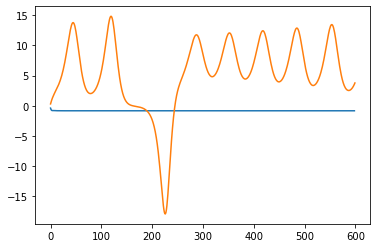

In [18]:
plt.plot(y_pred2[1:600,0])
plt.plot(X_test[400:,0])

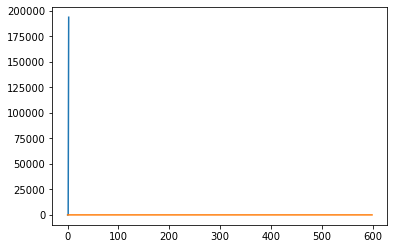

In [19]:
plt.plot(y_pred3[1:600,0])
plt.plot(X_test[400:,0])

# finding an initial condition for noisy and missing observations 

In [20]:
observations = np.copy(X_test[:,:1])*np.nan
observations[::8,:] = X_test[::8,:1] + np.random.normal(0,2,X_test[::8,:1].shape[0]).reshape(X_test[::8,:1].shape[0],1)

In [21]:
initial_cond_idx = 400
length_prior     = 400
train_series = torch.from_numpy(X_train).float()
inp_init_knn, inp_init_opti = get_initial_condition(model_Multi_RINN, torch.from_numpy(observations[initial_cond_idx:initial_cond_idx+length_prior,:1]).float(), train_series, 0.01,lr_init = 0.001, err_tol = 1E-1, n_train = 10000, get_init_in_train_set = True)

torch.Size([400, 1])


IndexError: index 0 is out of bounds for axis 0 with size 0

In [22]:
y_pred3=np.zeros((2000+length_prior+1,params['dim_Embedding']))
tmp = inp_init_opti
y_pred3[0,:] = tmp.cpu().data.numpy()
for k in range(1,2000+length_prior+1):
    y_pred3[k,:] = modelRINN(tmp,0.01)[0].cpu().data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred3[k,:],(1,params['dim_Embedding']))).float())

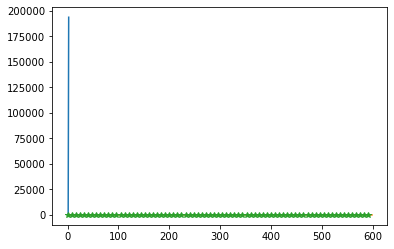

In [23]:
plt.plot(y_pred3[1:600,0])
plt.plot(X_test[400:,0])
plt.plot(observations[400:,0],'*')